In [1]:
import os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Global Variables
BASE_DIR = "E:\\workspace\\stock"
RUN_DATE = '20220304' # str(datetime.now())[:10].replace('-','')

DATA_DIR = os.path.join(BASE_DIR,'data', RUN_DATE) # path to save processed data files
MODEL_DIR = os.path.join(BASE_DIR,'python/tf/models') # path where the model spec is located


E:\workspace\stock E:\workspace\stock\data\20220304 E:\workspace\stock\python/tf/models


# Load OOT data set

In [4]:
with open(os.path.join(DATA_DIR, 'oot-xl.npz'), 'rb') as fp:
    oot_data = np.load(fp)
    oot_X_arr, oot_S_arr, oot_P_arr, oot_I_arr, oot_Y_arr, oot_R_arr = oot_data['x'], oot_data['s'], oot_data['p'],oot_data['i'],oot_data['y'],oot_data['r']

# Load model

In [6]:
models = []
models.append(
   tf.keras.models.load_model(os.path.join(MODEL_DIR,'./XL-L60D64L32FC16BN-v1.h5'))
)


In [96]:
from itertools import product
class ScoreEval() :
    
    def __init__(self, models):
        self.scores = []
        self.models = models
        self.metrics = []
        self.cutset = []
        self.ivset = []
        self.cmap = ['red', 'green', 'orange', 'blue', 'purple', 'pink', 'grey']
        
    def _initialize_plot(self, figsize=(16,8)) :
        
        fig, axes = plt.subplots(len(self.models),1, figsize=(figsize[0], figsize[1]*len(self.models)))
        if type(axes) != np.array : 
            return fig, np.array([axes])
        return fig, axes

    def run_score(self, X, Y, func=None) :
        self.scores = []
        for model in self.models :
            if func :
                pred = func(model, X)
                pred = pred.reshape((pred.shape[0], 1))
            else :
                pred = model.predict(X)
            pred = pd.DataFrame.from_records(pred)
            pred.columns=['score']
            final = Y.merge(pred, how='inner', left_index=True, right_index=True)
            self.scores.append(final)
    
    def score_cut(self, cut_step=0.02, buckets=100):

        self.cutset = []
        self.opset  = []
        
        for eval_df in self.scores :
            # Evaluation on score cutoff
            cutoff = np.arange(0, 1, cut_step)
            pre_cut = pd.DataFrame()
            acc_cut = pd.DataFrame()
            for c in cutoff :
                topc = eval_df.loc[eval_df['score'] >= c, :]
                pre  = pd.Series([c, (topc['label'] == 1).sum() / topc.shape[0], (topc['label'] == 1).sum() / (eval_df['label']==1).sum(), topc.shape[0], (topc['label'] == 1).sum() ])
                pre_cut = pre_cut.append(pre, ignore_index=True)
        #         acc  = pd.Series([c, (topc['truth'] == topc['score']).sum() / topc.shape[0], topc.shape[0]])
            pre_cut.columns = ['cutoff', 'precision', 'recall', 'sequence_captured', '1_seq_captured']
            self.cutset.append(pre_cut)
            
            # Evaluation on Operation point. 
            ops = range(0, eval_df.shape[0], eval_df.shape[0] // buckets)
            eval_df1 = eval_df.sort_values('score', ascending=False)
            pre_df = pd.DataFrame()
            for i in ops :
            #     print(i)
                if i == 0 :
                    continue
                topi = eval_df1.iloc[:i,]
                pre  = pd.Series([(topi['label'] == 1).sum() / i])
                rec  = pd.Series([(topi['label'] == 1).sum() / (eval_df1['label'] == 1).sum()])
                rlt0 = pd.concat([pre, rec], axis=1)
            #     print(rlt0.head())
                pre_df = pre_df.append(rlt0, ignore_index=True)
            pre_df.columns=['precision', 'recall']
            pre_df = pre_df.reset_index()
            
            self.opset.append(pre_df)
            
    def daily_recall(self, figsize=(16,8), qtl_list = ['r99', 'r95', 'r90','r50',], x_step=2):
        
        fig, axes = self._initialize_plot(figsize=(figsize[0], figsize[1]*len(self.models)))
        
        for ax, data in zip(axes, self.scores) :
        
            data1 = data.copy()
            # tp : true positive
            data1['tp99'] = data1.apply(lambda x : x['label']==1 and x['score']>=0.99, axis=1)
            data1['tp95'] = data1.apply(lambda x : x['label']==1 and x['score']>=0.95, axis=1)
            data1['tp90'] = data1.apply(lambda x : x['label']==1 and x['score']>=0.90, axis=1)
            data1['tp75'] = data1.apply(lambda x : x['label']==1 and x['score']>=0.75, axis=1)
            data1['tp50'] = data1.apply(lambda x : x['label']==1 and x['score']>=0.50, axis=1)
            data1['tp25'] = data1.apply(lambda x : x['label']==1 and x['score']>=0.25, axis=1)
            data1['tp10'] = data1.apply(lambda x : x['label']==1 and x['score']>=0.10, axis=1)
            data1['tp01'] = data1.apply(lambda x : x['label']==1 and x['score']>=0.01, axis=1)
            # ap : all positive
            data1['ap99'] = data1.apply(lambda x : x['label']==1, axis=1)
            data1['ap95'] = data1.apply(lambda x : x['label']==1, axis=1)
            data1['ap90'] = data1.apply(lambda x : x['label']==1, axis=1)
            data1['ap75'] = data1.apply(lambda x : x['label']==1, axis=1)
            data1['ap50'] = data1.apply(lambda x : x['label']==1, axis=1)
            data1['ap25'] = data1.apply(lambda x : x['label']==1, axis=1)
            data1['ap10'] = data1.apply(lambda x : x['label']==1, axis=1)
            data1['ap01'] = data1.apply(lambda x : x['label']==1, axis=1)
            
            stats_bydate = data1.groupby('date').agg(pd.Series.sum).reset_index()
#             print(stats_bydate.head())
            stats_bydate['r99'] = stats_bydate.apply(lambda x : x['tp99'] / (x['ap99'] + 0.0001), axis=1)
            stats_bydate['r95'] = stats_bydate.apply(lambda x : x['tp95'] / (x['ap95'] + 0.0001), axis=1)
            stats_bydate['r90'] = stats_bydate.apply(lambda x : x['tp90'] / (x['ap90'] + 0.0001), axis=1)
            stats_bydate['r75'] = stats_bydate.apply(lambda x : x['tp75'] / (x['ap75'] + 0.0001), axis=1)
            stats_bydate['r50'] = stats_bydate.apply(lambda x : x['tp50'] / (x['ap50'] + 0.0001), axis=1)
            stats_bydate['r25'] = stats_bydate.apply(lambda x : x['tp25'] / (x['ap25'] + 0.0001), axis=1)
            stats_bydate['r10'] = stats_bydate.apply(lambda x : x['tp10'] / (x['ap10'] + 0.0001), axis=1)
            stats_bydate['r01'] = stats_bydate.apply(lambda x : x['tp01'] / (x['ap01'] + 0.0001), axis=1)
            
            ax.bar(stats_bydate['date'], stats_bydate['label'], color = 'lightsteelblue')

            
            date_axis = stats_bydate['date']
            # ax2.set_xlim(-1, stats.shape[0])
            ax.set_xticks([ i for i in range(0, len(date_axis), x_step) ])
            ax.set_xticklabels([ date_axis[i] for i in range(0, len(date_axis), x_step) ])
            plt.xticks(rotation=90)
            
            ax2 = ax.twinx()

            ax2.set_xticks([ i for i in range(0, len(date_axis), x_step) ])
            ax2.set_xticklabels([ date_axis[i] for i in range(0, len(date_axis), x_step) ])
            plt.xticks(rotation=90)

            ax2.plot(stats_bydate['date'], stats_bydate['r99'])
            ax2.plot(stats_bydate['date'], stats_bydate['r95'])
            ax2.plot(stats_bydate['date'], stats_bydate['r90'])
#             ax2.plot(stats_bydate['date'], stats_bydate['r75'])
            ax2.plot(stats_bydate['date'], stats_bydate['r50'])
#             ax2.plot(stats_bydate['date'], stats_bydate['r25'])
#             ax2.plot(stats_bydate['date'], stats_bydate['r10'])
#             ax2.plot(stats_bydate['date'], stats_bydate['r01' ])
            date_axis = stats_bydate['date']

            handles = []
            for q in qtl_list :

                hdl, = ax2.plot(stats_bydate['date'], stats_bydate[q])
                handles.append(hdl)
            
            ax2.set_yticks(np.arange(0,1.02,0.02))
            ax2.grid(axis='y', linestyle='--')

            plt.legend(handles=handles, labels=qtl_list, loc='best')            
        plt.show()
        
    def daily_precision(self, figsize=(16,8), qtl_list = ['p99', 'p95', 'p90','p50',], x_step=2):
        fig, axes = self._initialize_plot(figsize=(figsize[0], figsize[1]*len(self.models)))

        for ax, data in zip(axes, self.scores) :
            data1 = data.copy()
            # tp : true positive
            data1['tp99'] = data1.apply(lambda x : x['label']==1 and x['score']>=0.99, axis=1)
            data1['tp95'] = data1.apply(lambda x : x['label']==1 and x['score']>=0.95, axis=1)
            data1['tp90'] = data1.apply(lambda x : x['label']==1 and x['score']>=0.90, axis=1)
            data1['tp75'] = data1.apply(lambda x : x['label']==1 and x['score']>=0.75, axis=1)
            data1['tp50'] = data1.apply(lambda x : x['label']==1 and x['score']>=0.50, axis=1)
            data1['tp25'] = data1.apply(lambda x : x['label']==1 and x['score']>=0.25, axis=1)
            data1['tp10'] = data1.apply(lambda x : x['label']==1 and x['score']>=0.10, axis=1)
            data1['tp01'] = data1.apply(lambda x : x['label']==1 and x['score']>=0.01, axis=1)
            # sc : score cut
            data1['sc99'] = data1.apply(lambda x : x['score']>=0.99, axis=1)
            data1['sc95'] = data1.apply(lambda x : x['score']>=0.95, axis=1)
            data1['sc90'] = data1.apply(lambda x : x['score']>=0.90, axis=1)
            data1['sc75'] = data1.apply(lambda x : x['score']>=0.75, axis=1)
            data1['sc50'] = data1.apply(lambda x : x['score']>=0.50, axis=1)
            data1['sc25'] = data1.apply(lambda x : x['score']>=0.25, axis=1)
            data1['sc10'] = data1.apply(lambda x : x['score']>=0.10, axis=1)
            data1['sc01'] = data1.apply(lambda x : x['score']>=0.01, axis=1)
            
            stats_bydate = data1.groupby('date').agg(pd.Series.sum).reset_index()

            stats_bydate['p99'] = stats_bydate.apply(lambda x : x['tp99'] / (x['sc99'] + 0.0001), axis=1)
            stats_bydate['p95'] = stats_bydate.apply(lambda x : x['tp95'] / (x['sc95'] + 0.0001), axis=1)
            stats_bydate['p90'] = stats_bydate.apply(lambda x : x['tp90'] / (x['sc90'] + 0.0001), axis=1)
            stats_bydate['p75'] = stats_bydate.apply(lambda x : x['tp75'] / (x['sc75'] + 0.0001), axis=1)
            stats_bydate['p50'] = stats_bydate.apply(lambda x : x['tp50'] / (x['sc50'] + 0.0001), axis=1)
            stats_bydate['p25'] = stats_bydate.apply(lambda x : x['tp25'] / (x['sc25'] + 0.0001), axis=1)
            stats_bydate['p10'] = stats_bydate.apply(lambda x : x['tp10'] / (x['sc10'] + 0.0001), axis=1)
            stats_bydate['p01'] = stats_bydate.apply(lambda x : x['tp01'] / (x['sc01'] + 0.0001), axis=1)
            
            ax.bar(stats_bydate['date'], stats_bydate['label'], color = 'lightsteelblue')

            
            date_axis = stats_bydate['date']
            # ax2.set_xlim(-1, stats.shape[0])
            ax.set_xticks([ i for i in range(0, len(date_axis), x_step) ])
            ax.set_xticklabels([ date_axis[i] for i in range(0, len(date_axis), x_step) ])
         
            plt.xticks(rotation=90)
            
            ax2 = ax.twinx()

            ax2.set_xticks([ i for i in range(0, len(date_axis), x_step) ])
            ax2.set_xticklabels([ date_axis[i] for i in range(0, len(date_axis), x_step) ])

            plt.xticks(rotation=90)

            handles = []
            for q in qtl_list :

                hdl, = ax2.plot(stats_bydate['date'], stats_bydate[q])
                handles.append(hdl)
            
            ax2.set_yticks(np.arange(0,1.02,0.02))
            ax2.grid(axis='y', linestyle='--')

            plt.legend(handles=handles, labels=qtl_list, loc='best')            
            # plt.legend(handles=[ax], labels="ABCDEFGH", loc='best')
        plt.show()


    def daily_qtls(self, figsize=(16,8), qtl_list = ['q99', 'q95', 'q90','q75','q50', 'q25','q10','q01'], x_step=2 ) :
        
        fig, axes = self._initialize_plot(figsize=(figsize[0], figsize[1]*len(self.models)))
        for ax, data in zip(axes, self.scores) :
            stats_bydate = data.groupby('date').agg({
                'label': pd.Series.sum, 
                'score': [lambda x: np.quantile(x, 0.99), lambda x: np.quantile(x, 0.95), lambda x: np.quantile(x, 0.9), 
                          lambda x: np.quantile(x, 0.75),  lambda x: np.quantile(x, 0.5), lambda x: np.quantile(x, 0.25),
                          lambda x: np.quantile(x, 0.1), lambda x: np.quantile(x, 0.01)
                         ]
            #     'score': [lambda x: sum(x > 0.99), lambda x: sum(x > 0.9), lambda x: sum(x > 0.8), lambda x: sum(x > 0.99)]
            }).reset_index()
            stats_bydate.columns = [
                'date',
                'label_cnt', 
                'q99', 
                'q95', 
                'q90',
                'q75',
                'q50', 
                'q25',
                'q10',
                'q01'
            ]
            
            ax.bar(stats_bydate['date'], stats_bydate['label_cnt'], color = 'lightsteelblue')
            # ax.set_xticks(range(0, stats_bydate['label_cnt'].max(), 10))
            # ax2.set_xticklabels(stats.loc[stats.index.isin(range(0,stats.shape[0], x_step)), by])

            date_axis = stats_bydate['date'].unique()
            
            ax.set_xticks([ i for i in range(0, len(date_axis), x_step) ])
            ax.set_xticklabels([ date_axis[i] for i in range(0, len(date_axis), x_step) ])
         
            plt.xticks(rotation=90)
            
            ax2 = ax.twinx()

            ax2.set_xticks([ i for i in range(0, len(date_axis), x_step) ])
            ax2.set_xticklabels([ date_axis[i] for i in range(0, len(date_axis), x_step) ])

            plt.xticks(rotation=90)

            handles = []
            for q in qtl_list :

                hdl, =ax2.plot(stats_bydate['date'], stats_bydate[q])
                handles.append(hdl)

            ax2.set_yticks(np.arange(0,1.02,0.02))
            ax2.set_ylim(0,1.02)
            ax2.grid(axis='y', linestyle='--')


            plt.legend(handles=handles, labels=qtl_list, loc='best')            
        plt.show()
    
    def iv(self, bins=20, plot=True, figsize=(10, 10), bin_col='score_bin') :

        fig, axes = self._initialize_plot(figsize=(figsize[0], figsize[1]*len(self.models)))
        
        for ax, data in zip(axes, self.scores) :
            # score distribution
            data_final_1 = data.assign(
                score_bin = pd.cut(data['score'], bins),
                score_qtl = pd.qcut(data['score'], bins),
            )

            N0 = (data_final_1['label'] == 0).sum()
            N1 = (data_final_1['label'] == 1).sum()

            
            data_final_2 = data_final_1.groupby(bin_col).agg({
                'label' : [pd.Series.count, pd.Series.sum]
            })

            data_final_2.columns = ['cnt', 'inc']

            data_final_2 = data_final_2.reset_index()
            data_final_2 = data_final_2.assign(
                woe = lambda x: np.log(x['inc'] / N1) - np.log((x['cnt'] - x['inc'] ) / N0),
                binbd = data_final_2[bin_col].apply(lambda x: x.right),
            )

            # print(data_final_2.head())

            score_iv = np.sum((data_final_2['inc'] / N1 - (data_final_2['cnt'] - data_final_2['inc'])/ N0) * data_final_2['woe'])
            
            self.ivset.append(score_iv)
            
            if plot :
                cmap = self.cmap
                ax.bar( data_final_2.index, data_final_2['woe'], color=(data_final_2['woe']<=0).astype(int).apply(lambda x: cmap[x]))
                ax.set_xticklabels(data_final_2['binbd'])
                ax.set_title('IV:{}'.format(score_iv))
    
    def score_distribution(self, bins=20, plot=True, figsize=(10, 10), bin_col='score_bin') :

        fig, axes = self._initialize_plot(figsize=(figsize[0], figsize[1]*len(self.models)))
        
        for ax, data in zip(axes, self.scores) :
            # score distribution
            data_final_1 = data.assign(
                score_bin = pd.cut(data['score'], bins),
                score_qtl = pd.qcut(data['score'], bins),
            )

            
            data_final_2 = data_final_1.groupby(bin_col).agg({
                'label' : [pd.Series.count, pd.Series.sum]
            })

            data_final_2.columns = ['cnt', 'inc']

            data_final_2 = data_final_2.reset_index()
            data_final_2 = data_final_2.assign(
                binbd = data_final_2[bin_col].apply(lambda x: x.right),
            )
            
            if plot :
                cmap = self.cmap
                ax.bar( data_final_2.index, data_final_2['cnt'], color=cmap[2])
        
    def plot_cutoff_chart(self, index_col=None, x_step=2, save_path=None, figsize=(10,10)) :
        
        fig, ax = plt.subplots(1,1, figsize=figsize)
        ax.ylim=(0,1)
        ax.y_ticks=(0,1)
        
        ax2 = ax.twinx()
        handles = []
        for pre_df in self.cutset :
            
            p1, = ax.plot(pre_df.loc[(~pre_df['precision'].isnull()) & (pre_df['precision']>0.0), 'precision'])
            p2, = ax2.plot(pre_df.loc[(~pre_df['recall'].isnull()) & (pre_df['recall']>0.0), 'recall'],  linestyle='--')
            
            handles.extend([p1, p2])

        ax.set_ylabel('precesion')
        ax.set_ylim(0,1.02)

        ax.set_xticks(range(0, pre_df.shape[0], x_step))
        ax.grid(which='both', axis='both')

        ax2.set_ylabel('recall')
        ax2.set_ylim(0,1.02)
        ax2.grid(which='both', axis='both', linestyle='--')
        
        plt.legend(handles=handles, labels=product([ i for i in range(len(self.models)) ], ['precision', 'recall']), loc='best')            


        if index_col:
            ax.set_xticklabels(pre_df[index_col].map(lambda x: round(x,2)).iloc[0: pre_df.shape[0]+1:x_step])
        plt.xticks(rotation=90)
        
        if save_path: 
            plt.savefig(save_path)
        else :
            plt.show()
        plt.close()
        
    def plot_op_chart(self, index_col=None, x_step=2, save_path=None, figsize=(10,10)) :
        
        fig, ax = plt.subplots(1,1, figsize=figsize)
        ax.ylim=(0,1)
        ax.y_ticks=(0,1)
        
        ax2 = ax.twinx()
        handles = []
        for pre_df in self.opset :
            
            p1, = ax.plot(pre_df.loc[(~pre_df['precision'].isnull()) & (pre_df['precision']>0.0), 'precision'])
            
        
            p2, = ax2.plot(pre_df.loc[(~pre_df['recall'].isnull()) & (pre_df['recall']>0.0), 'recall'],  linestyle='--')
            
            handles.extend([p1, p2])

        ax.set_ylabel('precesion')
        ax.set_ylim(0,1.02)
        ax.set_xlim(-0.02, 100)
        ax.set_xticks(range(0, pre_df.shape[0], x_step))
        ax.grid(which='both', axis='both')

        ax2.set_ylabel('recall')
        ax2.set_ylim(0,1.02)
        
        ax2.set_xlim(-0.02, 100)
        ax2.grid(which='both', axis='both', linestyle='--')


        plt.legend(handles=handles, labels=product([ i for i in range(len(self.models)) ], ['precision', 'recall']), loc='best')            

        if index_col:
            ax.set_xticklabels(pre_df[index_col].map(lambda x: round(x,2)).iloc[0: pre_df.shape[0]+1:x_step])
        plt.xticks(rotation=90)
        
        if save_path: 
            plt.savefig(save_path)
        else :
            plt.show()
        plt.close()

    def plot_pr(self, tick_step=0.02, save_path=None, figsize=(10,10)) :
        
        fig, ax = plt.subplots(1,1, figsize=figsize)
        
        ax.ylim=(0,1)
        ax.y_ticks=(0,1)
        
        handles = []
        for pre_df in self.opset :
            p1, = ax.plot(
                pre_df.loc[(~pre_df['recall'].isnull()) & (pre_df['recall']>0.0), 'recall'],
                pre_df.loc[(~pre_df['precision'].isnull()) & (pre_df['precision']>0.0), 'precision']
            )
            handles.append(p1)
            
        ax.set_ylabel('precision')
        ax.set_xlabel('recall')
        ax.set_xlim(0,1.02)
        ax.set_ylim(0,1.02)
        ax.grid(which='both', axis='both')
        
        plt.legend(handles=handles, labels=[ i for i in range(len(self.models)) ], loc='best')     
        
        if save_path: 
            plt.savefig(save_path)
        else :
            plt.show()
        plt.close()


In [65]:
df_y = pd.DataFrame(np.concatenate([oot_Y_arr, oot_R_arr],axis=1))
df_y.columns=['label', 'symbol', 'date']
df_y['label'] = df_y['label'].astype(np.float16).astype(np.int16)

In [9]:
df_y.head()

,label,symbol,date
0,0,SH603198,2021-11-02
1,0,SH603198,2021-06-17
2,0,SH603198,2021-07-20
3,0,SH600436,2021-07-01
4,0,SH600436,2021-03-10


In [97]:
se_oot = ScoreEval(models)
test_rows = 1000
se_oot.run_score([oot_X_arr[:test_rows],oot_S_arr[:test_rows],oot_P_arr[:test_rows],oot_I_arr[:test_rows],], df_y.head(test_rows))
se_oot.score_cut()

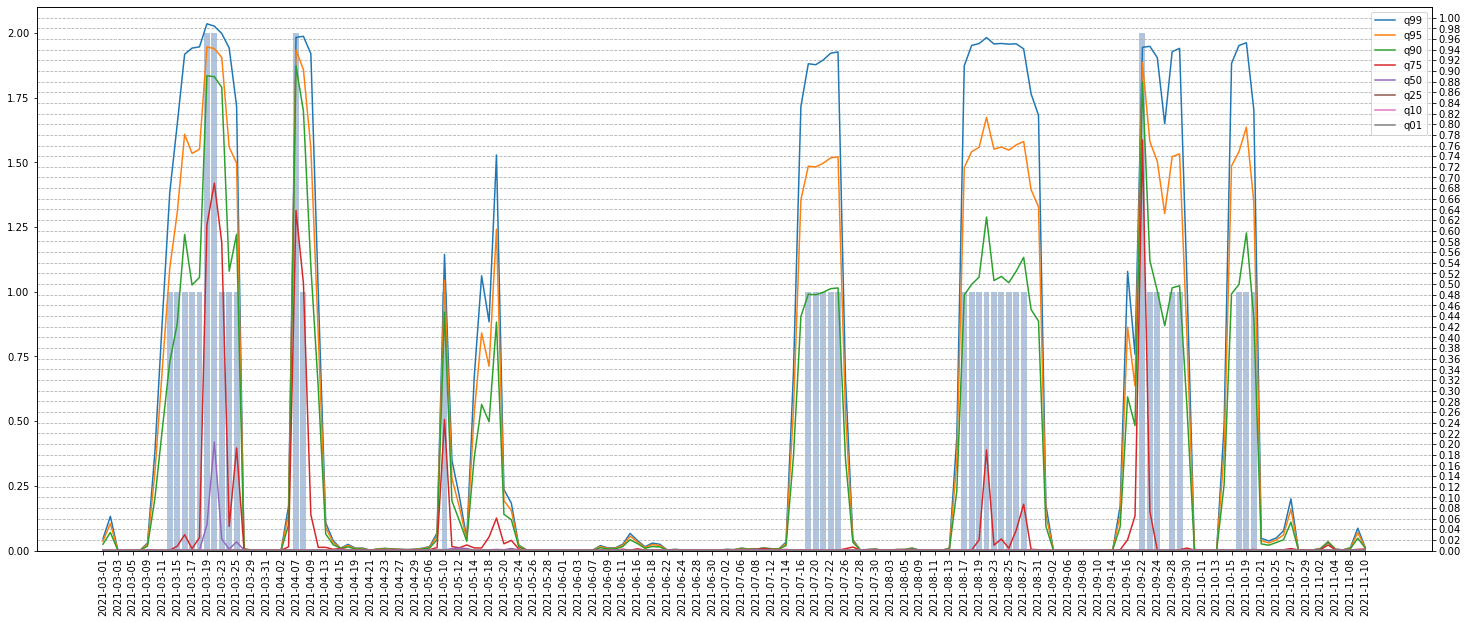

In [93]:
se_oot.daily_qtls(figsize=(25,10))

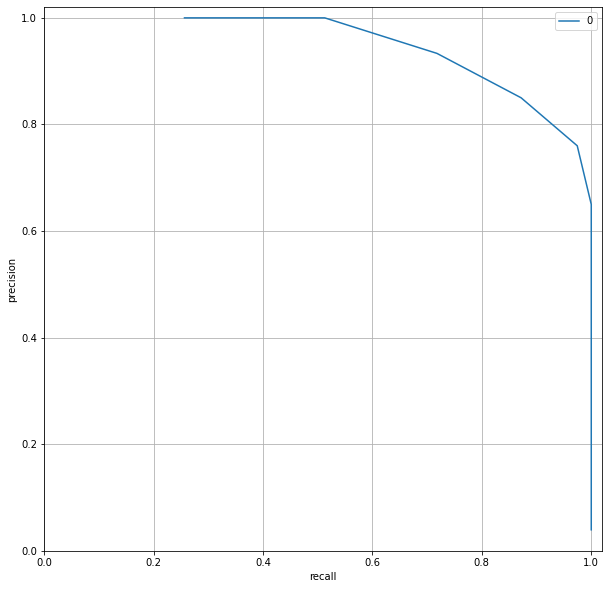

In [47]:
se_oot.plot_pr()

D:\Python\Python37\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Python\Python37\lib\site-packages\ipykernel_launcher.py:297: UserWarning: FixedFormatter should only be used together with FixedLocator


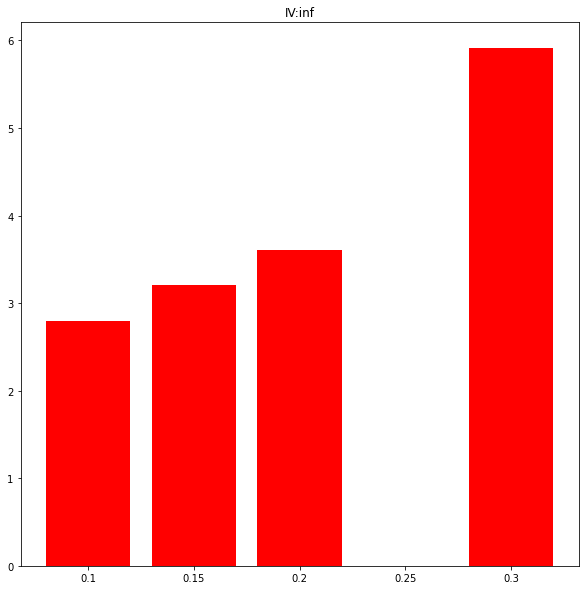

In [48]:
se_oot.iv()

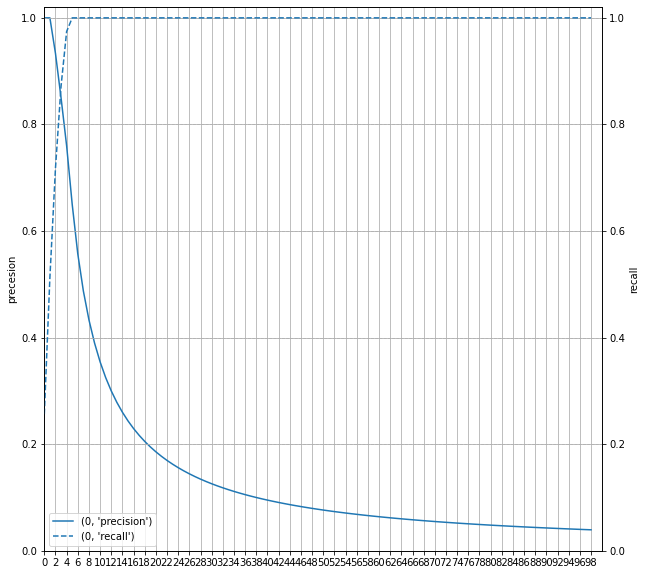

In [49]:
se_oot.plot_op_chart()

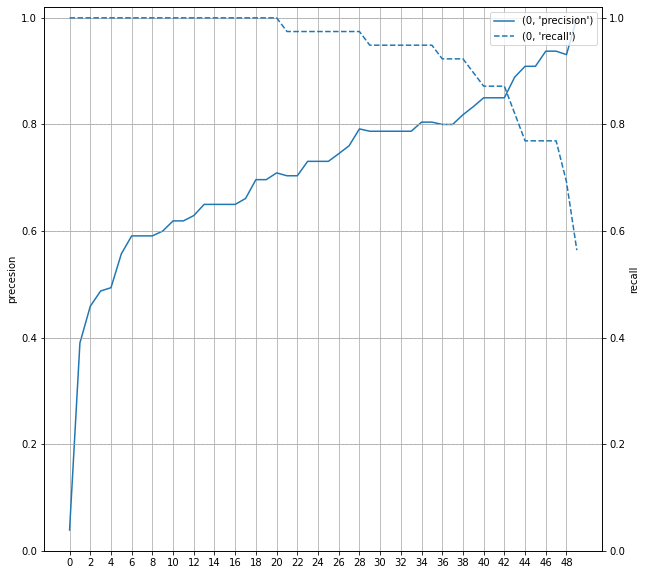

In [58]:
se_oot.plot_cutoff_chart()

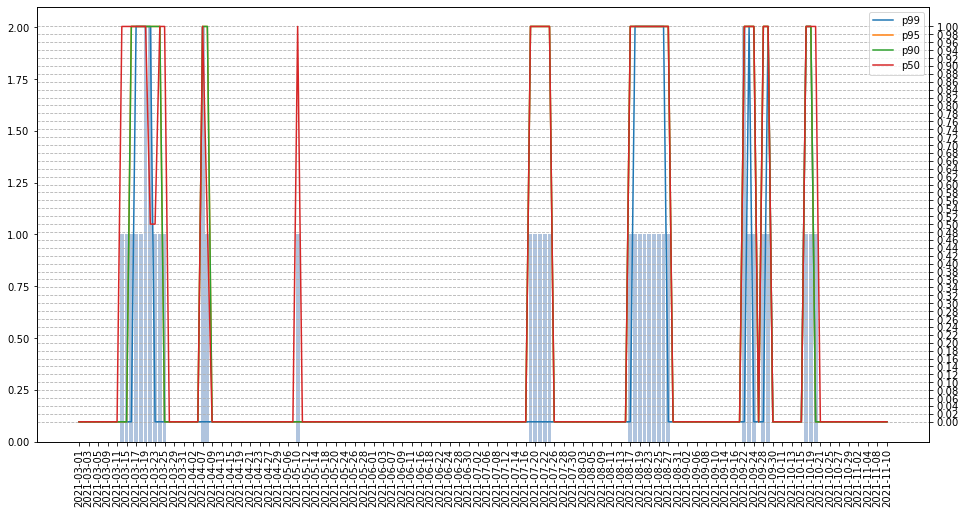

In [98]:
# The order of lines are blue->orange->green->red from cutoff high to low
se_oot.daily_precision()

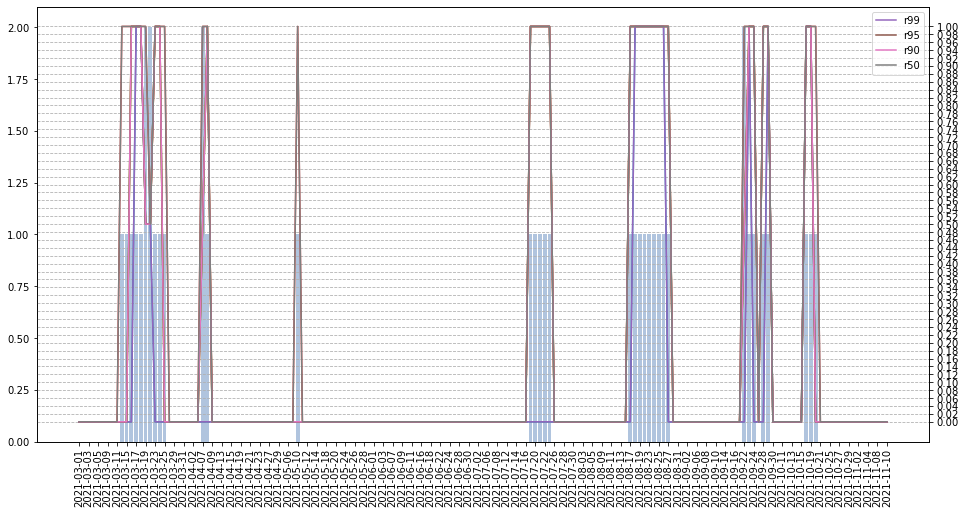

In [99]:
se_oot.daily_recall()